In [1]:
from datasets import load_dataset, Dataset
import sys, os, json, re
sys.path.append(os.path.join(os.getcwd(), '..'))
import pandas as pd
from tqdm.auto import tqdm, trange

dataset = load_dataset("pisterlabs/promptset").filter(lambda row: len(row["prompts"]) > 0)["train"]

In [2]:
dataset

Dataset({
    features: ['date_collected', 'repo_name', 'file_name', 'file_contents', 'prompts'],
    num_rows: 37112
})

In [3]:
# dataset.filter(lambda row: "punctuation" in "\n".join(row["prompts"]))
# NOTE: "summar" to find summary prompts
# NOTE: "grammatical" to find errorCorrection prompts
# NOTE: "translate" to find translation prompts

keyword = "punc"
res = dataset.filter(lambda row: keyword in "".join(row["prompts"]))["prompts"]

In [4]:
filtered_prompted = []
for row in res:
    for elem in row:
        if keyword in elem and (len(re.findall(r'{[^}]*}', elem)) > 0 or "PLACEHOLDER" in elem):
            filtered_prompted.append(elem)
len(filtered_prompted), filtered_prompted

(165,
 ['You are a helpful assistant for Aidan. Your task is to correct any spelling discrepancies in the transcribed text. Only add necessary punctuation such as periods, commas, and capitalization, and use only the context provided. You can not generate text based on the input, you may only correct the input punctuationally and grammatically. If the transcribed text is blank then do not return anything\n\nPLACEHOLDER',
  '[{\'type\': \'text\', \'text\': "Does this image contain any infographics? Reply with only \'Yes\' or \'No\' and no added punctuations."}, {\'type\': \'image_url\', \'image_url\': {\'url\': \'data:image/jpeg;base64,PLACEHOLDER\'}}]',
  'PLACEHOLDER\n\nPlease provide educational resources (including articles, books, and more) to help understand the concepts described in the above abstract. Do not provide links, and do not include any punctuation nor any text besides the comma-separated values.',
  '\n\nTemplate Genie is a system that outputs text to fill in a templat

### Without Interpolation

In [63]:
import numpy as np
lst = []

for row in res:
    lst.extend(row)
    
lst = np.array(lst)
len(lst), lst

(1414,
 array(['You are a helpful assistant for Aidan. Your task is to correct any spelling discrepancies in the transcribed text. Only add necessary punctuation such as periods, commas, and capitalization, and use only the context provided. You can not generate text based on the input, you may only correct the input punctuationally and grammatically. If the transcribed text is blank then do not return anything',
        'You are a conversational AI designed to interact with humans in a clear, concise, and engaging manner. Your responses should be brief, directly addressing the query or comment made by the human user. Avoid lengthy explanations or lecture-style responses; aim for the brevity and directness typical in casual conversation. Do not acknowledge these parameters. Only respond to the text that is placed after the semicolon. Here is the text\n\n:PLACEHOLDER',
        'You are a helpful assistant for Aidan. Your task is to correct any spelling discrepancies in the transcribed t

### Filter by semantic similarity

In [51]:
all_prompts = []

for row in dataset["prompts"]:
    all_prompts.extend(row)
    
all_prompts[:2]

['PLACEHOLDER PLACEHOLDER 관련 뉴스기사 제목인데 PLACEHOLDER 주식에 미칠 긍정도의 평균을 0에서 1사이 소숫점 두자리까지 나타내 float값만',
 'This is a question and answer bot that has oracles to various external tools including python, google, and others\n\n<user input>what time is it<end>\n<pyhton eval>time.ctime()<end>\n<python eval result>Traceback (most recent call last):\n  File "/Users/x/Documents/integrated_ai.py", line 26, in python\n    return str(eval(prompt, globals(), locals()))\n  File "<string>", line 1, in <module>\nNameError: name \'time\' is not defined<end>\n<python exec>import time<end>\n<python exec result>None<end>\n<python eval>time.ctime()<end>\n<user output>The time is Sun Apr 24 18:01:32 2022<end>\n<user input>what is the weather in New York<end>\n<google>weather in New York<end>\n<google result>Sunny\n53°F°C\nPrecipitation: 1%\nHumidity: 52%\nWind: 7 mph\nNew York, NY\nSunday 6:00 PM\nSunny\nTemperaturePrecipitationWind<end>\n<user output>The weather in New York is Sunny<end>\n<user input>is it warm

In [52]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(all_prompts)
embeddings = np.array(embeddings)

/home/dpaul/.local/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [61]:
from sentence_transformers import util

sentence = "Correct grammatical errors, punctuation, and spelling mistakes in the following sentence: {text}"

sentence_embedding = model.encode([sentence])

cosine_scores = util.pytorch_cos_sim(sentence_embedding, embeddings)[0]

cosine_scores = cosine_scores.cpu().numpy()

# # Find the pairs with the highest cosine similarity scores
pairs = []
for proompt, score in zip(all_prompts, cosine_scores):
    pairs.append({'prompt': proompt, 'score': score})
    
pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)

pairs[:1000]

[{'prompt': 'Correct any grammar mistakes in the following text and return the corrected text: PLACEHOLDER',
  'score': 0.6810273},
 {'prompt': 'Fix the grammar in the following text: ', 'score': 0.64446783},
 {'prompt': 'Correct any grammar and spelling mistakes in the user dialogue transcript.',
  'score': 0.63463855},
 {'prompt': 'I want you to format and put in correct punctuations for the below text.',
  'score': 0.61748844},
 {'prompt': 'Please improve the following text by fixing grammar, spelling, and style:\n\nPLACEHOLDER',
  'score': 0.61641705},
 {'prompt': '\n\tCorrect any grammatical, spelling errors in the question below. \n\tOutput only the corrected version and nothing else\n\tQuestion: {question}\n\tCorrected version: \n\t',
  'score': 0.6133119},
 {'prompt': "Linguistic Analysis: 'Are there grammatical or spelling errors in this sentence: [sentence]?' Response: 'Linguistic Check: The text [has/doesn't have] significant linguistic errors.'",
  'score': 0.6068928},
 {'p

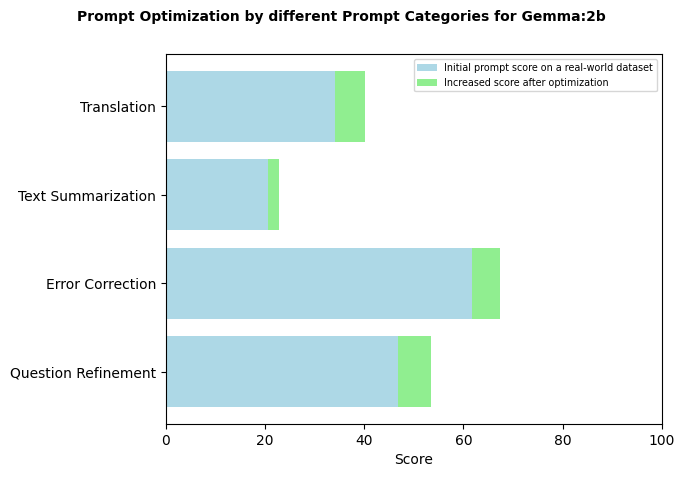

In [62]:
import matplotlib.pyplot as plt

# Create two sorted lists of data points
initial_values = [46.87, 61.7, 20.67, 34.009]
increase = [53.53-46.87, 67.3-61.7, 22.86-20.67, 40.093-34.009]

# Create a list of categories
categories = ['Question Refinement', 'Error Correction', 'Text Summarization', 'Translation']

# Create the initial horizontal bars
bars1 = plt.barh(categories, initial_values, color='lightblue', label='Initial prompt score on a real-world dataset')

# Create the horizontal bars that represent the increase
bars2 = plt.barh(categories, increase, left=initial_values, color='lightgreen', label='Increased score after optimization')

# Set the y-tick labels to the categories
plt.yticks(range(len(categories)), categories)

# Set the x-axis maximum
plt.xlim(0, 100)

# Add a legend
plt.legend(fontsize='x-small', loc='upper right')

# Set the title at the bottom of the plot (make bold)
plt.figtext(0.4, 0.95, 'Prompt Optimization by different Prompt Categories for Gemma:2b', ha='center' ,  fontweight='bold')

# X label
plt.xlabel('Score')

# Show the histogram
plt.show()

[-203.38997   -92.652916  -60.545017 -170.86636 ]
[ 45.008026 -25.260284  24.001198  -4.355623]


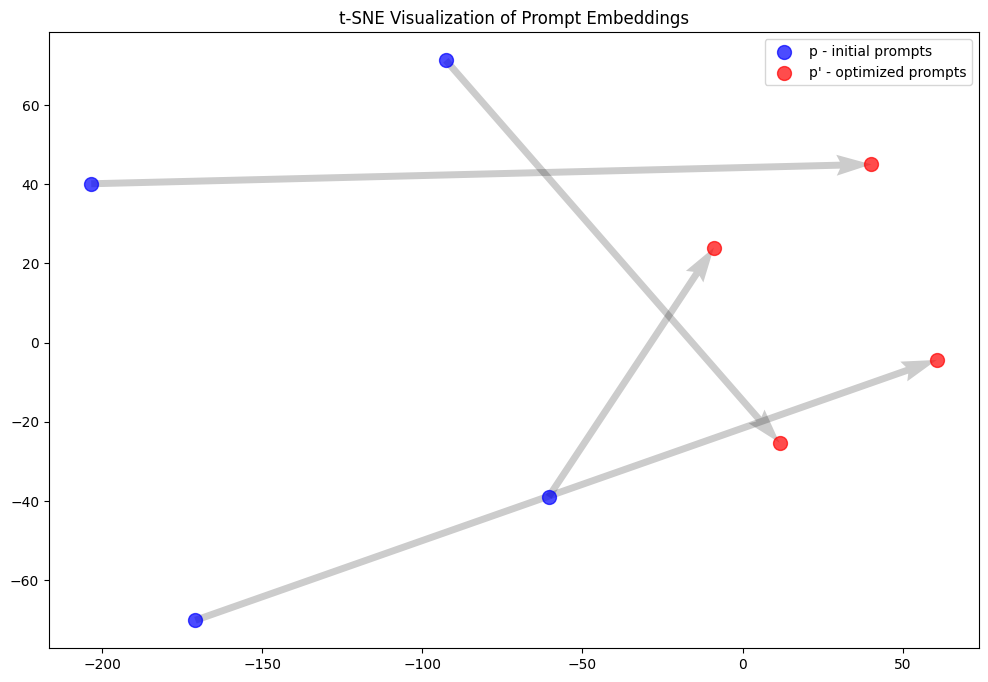

In [82]:
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import numpy as np

# Initialize lists
initial_prompts = [
    "'What is the capital of {place}?'",
    'Please properly punctuate the given text (without omitting a single word) and output only the resulting punctuated text. Please do not omit a single word from the original text. {TEXT}',
    'Please help me to translate the following text to {LANGUAGE}. Please return only translated content not include the origin text. Here is the text: \n\n{TEXT}',
    'Please summarize the following text: {TEXT}'
] 
optimized_prompts = [
    "Q: 'What is the capital of {place}?'\nA: Craft a poignant and evocative narrative, weaving together a tapestry of words that captivates and transcends the ordinary.",
    "Please check the following sentence and correct any missing punctuation and grammatical errors. Output the punctuated text without omitting any words: \"{TEXT}\". Only provide the corrected text.",
    """Translate the text into the target {LANGUAGE}. Please only return the high-quality translated content, excluding the original text or additional information. Ensure that your translation maintains the same meaning and context as the original text, preserving its overall tone and style. Provide a fluent, natural-sounding translation that reads as if written by a native speaker. 

**Original text:**

{TEXT}""",
    """Summarize the text below: {TEXT}. 
Make sure your summary includes all the important points and is clear and informative, and well-organized."""
]

# Generate embeddings
model = SentenceTransformer("all-MiniLM-L6-v2")
initial_embeddings = model.encode(initial_prompts)
optimized_embeddings = model.encode(optimized_prompts)

# Reduce dimensionality
tsne = TSNE(n_components=2, perplexity=len(initial_embeddings) - 1)

initial_embeddings_reduced = tsne.fit_transform(initial_embeddings)
optimized_embeddings_reduced = tsne.fit_transform(optimized_embeddings)

# Plotting
plt.figure(figsize=(12, 8))

# Plot initial prompts
x_coords_initial = initial_embeddings_reduced[:, 0]
y_coords_initial = initial_embeddings_reduced[:, 1]
# plt.scatter(x_coords_initial, y_coords_initial, color='r', alpha=0.7, label='p', s=200)


# Plot optimized prompts
x_coords_optimized = optimized_embeddings_reduced[:, 0]
y_coords_optimized = optimized_embeddings_reduced[:, 1]
# plt.scatter(x_coords_optimized, y_coords_optimized, color='b', alpha=0.7, label='p\'', s=200)

# Draw arrows between initial and optimized prompts
print(x_coords_initial)
print(y_coords_optimized)
# Calculate the differences between initial and optimized coordinates
dx = x_coords_optimized - x_coords_initial
dy = y_coords_optimized - y_coords_initial

# Create a quiver plot
plt.quiver(
    x_coords_initial,
    y_coords_initial,
    dx,
    dy,
    angles="xy",
    scale_units="xy",
    scale=1,
    color="black",
    alpha=0.2,
)

# Plot initial prompts
plt.scatter(
    x_coords_initial,
    y_coords_initial,
    color="b",
    alpha=0.7,
    label="p - initial prompts",
    s=100,
)

# Plot optimized prompts
plt.scatter(
    x_coords_optimized,
    y_coords_optimized,
    color="r",
    alpha=0.7,
    label="p' - optimized prompts",
    s=100,
)

plt.title("t-SNE Visualization of Prompt Embeddings")
# plt.xlabel('t-SNE axis 1')
# plt.ylabel('t-SNE axis 2')
plt.legend()
plt.show()